These jupyter can reproduced the results of figure2 in our papers.
you can use these functions we defined to evaluate the performance of each method with 10-X cross-validation.
If you want to use each method to analyse youe own data, please see the Tutorial.ipynb

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats


from scipy.spatial.distance import cdist
import h5py
from scipy.stats import spearmanr

import time
import torch
from IPython.display import display

from torch.nn.functional import softmax, cosine_similarity, sigmoid
import sys


we defined the funtions of each integration methods,
Please note :

if you want use normlized spatial and scRNA-seq data to integration,

For gimVI, SpaGE, Tangram, novoSpaRc and SpaOTsc, you must use normlized data as input, while,  

For Seurat and LIGER, you can use parameters norm == 'norm' directly with raw count file as input.

In [2]:

class GenePrediction:
    def __init__(self, RNA_path, Spatial_path, location_path, count_path = None, device = None, train_list = None, test_list = None, norm = 'count', outdir = None):
        """
        @author: wen zhang
        This function integrates two single-cell datasets, spatial and scRNA-seq, 
        and predictes the expression of the spatially unmeasured genes from the scRNA-seq data.
        
        Parameters
        -------
        RNA_path : str
            scRNA-seq data count file with Tab-delimited (cells X genes).
        Spatial_path : str
            spatial count data file with Tab-delimited, please note that the file has no index.
        location_path : str
            spatial spot coordinate file name with Tab-delimited, please note that the file has no index.
        count_path : str
            Option,  you must prepared this file when you want to use Tangram (tangram_seq_impute)to prediction gene spatial distribution.
        device : str
            Option,  [None,'GPU'], defaults to None
        train_list : list
            genes for integrations, you can support more than one train list.
        test_list : list
            genes for prediction, you can support more than one test list.
        norm : str
            Option,  ['count','norm'], defaults to count. if norm, Seurat and LIGER
            will normlize the  spatial and scRNA-seq data before intergration.
        outdir : str
            result file stored direction    
        """
        self.RNA_file = RNA_path
        self.Spatial_file = Spatial_path
        self.locations = np.loadtxt(location_path, skiprows=1)
        self.train_list = train_list
        self.test_list = test_list
        self.RNA_data_adata = sc.read(RNA_path, sep = "\t",first_column_names=True).T
        self.Spatial_data_adata = sc.read(Spatial_path, sep = "\t")
        self.device = device
        self.norm = norm
        print ('Please note you are using ' + self.norm + ' expression matrix to predict')
        if count_path != None:
            self.count =pd.read_table(count_path,sep='\t').astype(int)
            self.count[self.count.cell_counts==0]=1
        self.outdir = outdir
        
        
    def SpaGE_impute(self,args):
        sys.path.append("FigureData/SpaGE-master/")
        from SpaGE.main import SpaGE
        RNA_data = pd.read_table(self.RNA_file,header=0,index_col = 0)
        Spatial_data = pd.read_table(self.Spatial_file,sep='\t',header=0)
        RNA_data = RNA_data.loc[(RNA_data.sum(axis=1) != 0)]
        RNA_data = RNA_data.loc[(RNA_data.var(axis=1) != 0)]
        train_list, test_list = args
        predict = test_list
        feature = train_list

        if (len(feature)) < 50: 
            pv = int(len(feature)-3)
        else:
            pv = 50
        Spatial = Spatial_data[feature]
        Img_Genes = SpaGE(Spatial,RNA_data.T,n_pv=pv,genes_to_predict = predict)
        result = Img_Genes[predict]

        return result
    
    def gimVI_impute(self,args):
        import scvi
        import scanpy as sc
        from scvi.model import GIMVI
        Spatial_data_adata = self.Spatial_data_adata
        RNA_data_adata = self.RNA_data_adata
        train_list, test_list = args
        Genes  = list(Spatial_data_adata.var_names)
        rand_test_gene_idx = [Genes.index(x) for x in test_list]
        n_genes = len(Genes)
        rand_train_gene_idx = sorted(set(range(n_genes)) - set(rand_test_gene_idx))
        rand_train_genes = np.array(Genes)[rand_train_gene_idx]
        rand_test_genes = np.array(Genes)[rand_test_gene_idx]
        spatial_data_partial = Spatial_data_adata[:, rand_train_genes]
        sc.pp.filter_cells(spatial_data_partial, min_counts= 0)
        
        seq_data = copy.deepcopy(RNA_data_adata)
        
        seq_data = seq_data[:, Genes]
        sc.pp.filter_cells(seq_data, min_counts = 0)
        
        scvi.data.setup_anndata(spatial_data_partial)
        scvi.data.setup_anndata(seq_data)
        
        model = GIMVI(seq_data, spatial_data_partial)
        model.train(200)
        
        _, imputation = model.get_imputed_values(normalized=False)
        imputed = imputation[:, rand_test_gene_idx]
        result = pd.DataFrame(imputed, columns=rand_test_genes)
        return result
    
    def novoSpaRc_impute(self, args):
        import novosparc as nc
        RNA_data = pd.read_table(self.RNA_file,header=0,index_col = 0)
        Spatial_data = pd.read_table(self.Spatial_file,sep='\t',header=0)
        train_list, test_list = args
        gene_names = np.array(RNA_data.index.values)
        dge = RNA_data.values
        dge = dge.T
        num_cells = dge.shape[0]
        print ('number of cells and genes in the matrix:', dge.shape)
    
        hvg = np.argsort(np.divide(np.var(dge,axis=0),np.mean(dge,axis=0)+0.0001))
        dge_hvg = dge[:,hvg[-2000:]]
        
        num_locations = self.locations.shape[0]
    
        p_location, p_expression = nc.rc.create_space_distributions(num_locations, num_cells)
        cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(dge_hvg,self.locations,num_neighbors_source = 5,num_neighbors_target = 5)
        
        insitu_matrix = np.array(Spatial_data[train_list])
        insitu_genes = np.array(Spatial_data[train_list].columns)
        test_genes = np.array(test_list)
        test_matrix = np.array(Spatial_data[test_list])
        print (test_genes)
        print (insitu_genes)
        
        markers_in_sc = np.array([], dtype='int')
        for marker in insitu_genes:
            marker_index = np.where(gene_names == marker)[0]
            if len(marker_index) > 0:
                markers_in_sc = np.append(markers_in_sc, marker_index[0])
        
        cost_marker_genes = cdist(dge[:, markers_in_sc]/np.amax(dge[:, markers_in_sc]),insitu_matrix/np.amax(insitu_matrix))
        alpha_linear = 0.5
        gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(cost_marker_genes, cost_expression, cost_locations,alpha_linear, p_expression, p_location,'square_loss', epsilon=5e-3, verbose=True)
        sdge = np.dot(dge.T, gw)
        imputed = pd.DataFrame(sdge,index=RNA_data.index)
        result = imputed.loc[test_genes]
        result = result.T
        return result
    
    def SpaOTsc_impute(self, args):
        from spaotsc import SpaOTsc
        RNA_data = pd.read_table(self.RNA_file,header=0,index_col = 0)
        Spatial_data = pd.read_table(self.Spatial_file,sep='\t',header=0)
        train_list, test_list = args
        df_sc = RNA_data.T
        df_IS = Spatial_data
        pts = self.locations
        is_dmat = distance_matrix(pts, pts)
        
            
        df_is=df_IS.loc[:,train_list]
        
        gene_is=df_is.columns.tolist()
        gene_sc=df_sc.columns.tolist()
        gene_overloap=list(set(gene_is).intersection(gene_sc))
        a=df_is[gene_overloap]
        b=df_sc[gene_overloap]
        
        
        rho, pval = stats.spearmanr(a, b,axis=1)
        rho[np.isnan(rho)]=0
        mcc=rho[-(len(df_sc)):,0:len(df_is)]
        C = np.exp(1-mcc) 

        issc = SpaOTsc.spatial_sc(sc_data=df_sc, is_data=df_is, is_dmat = is_dmat)

        issc.transport_plan(C**2, alpha=0, rho=1.0, epsilon=1.0, cor_matrix=mcc, scaling=False)
        gamma = issc.gamma_mapping
        for j in range(gamma.shape[1]):
            gamma[:,j] = gamma[:,j]/np.sum(gamma[:,j])
        X_pred = np.matmul(gamma.T, np.array(issc.sc_data.values))

        result = pd.DataFrame(data=X_pred, columns=issc.sc_data.columns.values)
        test_genes = test_list
        result = result.loc[:,test_genes]  
        return result
    
    def Tangram_impute_image(self, args):
        sys.path.append("FigureData/Tangram-master/")
        import mapping.utils
        import mapping.mapping_optimizer
        import mapping.plot_utils
        train_list, test_list = args
        RNA_data = pd.read_table(self.RNA_file,header=0,index_col = 0).T
        adata= sc.AnnData(RNA_data)
        Spatial_data = pd.read_table(self.Spatial_file,sep='\t',header=0)
        device = self.device
        if self.device == 'GPU':
            device = torch.device('cuda:0')
        hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
                'lambda_count' : 1, 'lambda_f_reg' : 1}
        learning_rate = 0.1
        num_epochs = 1000
        
        gene_diff = train_list
        spatial_data = Spatial_data[gene_diff]
        space_data= sc.AnnData(spatial_data)
        
        S = np.array(adata[:, gene_diff] .X) 
        G = np.array(space_data.X) 
        d = np.full(G.shape[0], 1/G.shape[0])  
        S = np.log(1+S)
        mapper = mapping.mapping_optimizer.MapperConstrained(
            S=S, G=G, d=d, device=device, **hyperparm, target_count=G.shape[0])
        output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)
        pre_gene = np.dot(adata[:, test_list].X.T, output)
        pre_gene =pd.DataFrame(pre_gene,index=test_list,columns=space_data.obs_names).T
        
        return pre_gene
    
    def Tangram_impute_seq(self, args):
        if self.device == 'GPU':
            device = torch.device('cuda:0')
        train_list, test_list = args
        RNA_data = pd.read_table(self.RNA_file,header=0,index_col = 0).T
        adata= sc.AnnData(RNA_data)
        Spatial_data = pd.read_table(self.Spatial_file,sep='\t',header=0)
        device = self.device
        hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
                'lambda_count' : 1, 'lambda_f_reg' : 1}
        learning_rate = 0.1
        num_epochs = 6000
        
        gene_diff = train_list
        spatial_data = Spatial_data[gene_diff]
        space_data = sc.AnnData(spatial_data)
        space_data.obs['cell_count'] = self.count.cell_counts.values
        
        S = np.array(adata[:, gene_diff].X) 
        G = np.array(space_data.X) 
        d = np.array(space_data.obs.cell_count)/space_data.obs.cell_count.sum() 
        mapper = mapping.mapping_optimizer.MapperConstrained(
        S=S, G=G, d=d, device=device, **hyperparm, target_count = space_data.obs.cell_count.sum())
        output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)
        pre_gene = np.dot(adata[:, test_list].X.T, output)
        pre_gene =pd.DataFrame(pre_gene,index=test_list,columns=space_data.obs_names).T
        
        return pre_gene

    def pool(self, need_tools):
        if "SpaGE" in need_tools:
            
            with multiprocessing.Pool(10) as pool:
                result_SpaGE = pd.concat(pool.map(self.SpaGE_impute, iterable=zip(self.train_list, self.test_list)),axis=1) 
                if not os.path.exists(self.outdir):
                    os.mkdir(self.outdir)
                result_SpaGE.to_csv(self.outdir + "/result_SpaGE.csv",header=1, index=1)
                
        if "gimVI" in need_tools:
            with multiprocessing.Pool(10) as pool:
                result_GimVI = pd.concat(pool.map(self.gimVI_impute, iterable=zip(self.train_list, self.test_list)),axis=1) 
                if not os.path.exists(self.outdir):
                    os.mkdir(self.outdir)
                result_GimVI.to_csv(self.outdir + "result_gimVI.csv",header=1, index=1)
                
        if "novoSpaRc" in need_tools:
            
            with multiprocessing.Pool(10) as pool:
                result_Novosparc = pd.concat(pool.map(self.novoSpaRc_impute, iterable=zip(self.train_list, self.test_list)),axis=1) 
                if not os.path.exists(self.outdir):
                    os.mkdir(self.outdir)
                result_Novosparc.to_csv(self.outdir + "/result_novoSpaRc.csv",header=1, index=1)
                
        if "SpaOTsc" in need_tools:
            
            with multiprocessing.Pool(10) as pool:
                result_Spaotsc = pd.concat(pool.map(self.SpaOTsc_impute, iterable=zip(self.train_list, self.test_list)),axis=1) 
                if not os.path.exists(self.outdir):
                    os.mkdir(self.outdir)
                result_Spaotsc.to_csv(self.outdir + "/result_SpaOTsc.csv",header=1, index=1)
                
        if "Tangram_image" in need_tools:
            
            with multiprocessing.Pool(10) as pool:
                result_Tangram_image = pd.concat(pool.map(self.Tangram_impute_image, iterable=zip(self.train_list, self.test_list)),axis=1) 
                if not os.path.exists(self.outdir):
                    os.mkdir(self.outdir)
                result_Tangram_image.to_csv(self.outdir + "/result_Tangram_image.csv",header=1, index=1)
                
        if "Tangram_seq" in need_tools:
            
            with multiprocessing.Pool(10) as pool:
                result_Tangram_seq = pd.concat(pool.map(self.Tangram_impute_seq, iterable=zip(self.train_list, self.test_list)),axis=1) 
                if not os.path.exists(self.outdir):
                    os.mkdir(self.outdir)
                result_Tangram_seq.to_csv(self.outdir + "result_Tangram_seq.csv",header=1, index=1)

        if 'LIGER' in need_tools:
            RLiger = {}
            for k in range(len(self.train_list)):
                train = ','.join(self.train_list[k])
                test = ','.join(self.test_list[k])
                os.system('Rscript Benchmarking/Liger.r ' + self.RNA_file + ' ' + self.Spatial_file + ' ' + train + ' ' + test + ' ' + self.norm  + ' ' + self.outdir + '/Result_LIGER_' + str(k) + '.txt')

        if 'Seurat' in need_tools:
            RSeurat = {}
            for k in range(len(self.train_list)):
                train = ','.join(self.train_list[k])
                test = ','.join(self.test_list[k])
                os.system ('Rscript Benchmarking/Seurat.r ' + self.RNA_file + ' ' + self.Spatial_file + ' ' + train + ' ' + test + ' ' + self.norm + ' ' + self.outdir + '/Result_Seurat_' + str(k) + '.txt')

Prediction for osmFISH data

In [3]:
time_time_start=time.time()
PATH = 'FigureData/Figure2/Dataset2_osmFISH/Rawdata/'
RNA_path = PATH + 'scRNA_count.txt'
Spatial_path =  PATH + 'Insitu_count.txt'
location_path = PATH + 'Locations.txt'
Spatial_data = pd.read_table(Spatial_path,sep='\t',header=0)
train_list = (np.load(PATH + "train_list.npy", allow_pickle=True)).tolist()
test_list = (np.load(PATH + "test_list.npy", allow_pickle=True)).tolist()
outdir =  'FigureData/Figure2/Dataset2_osmFISH/'
if not os.path.exists(outdir):
        os.mkdir(outdir)
test = GenePrediction(RNA_path, Spatial_path, location_path, train_list = train_list, test_list = test_list, outdir = outdir)
Methods = ['SpaGE','novoSpaRc','SpaOTsc','Tangram_image','gimVI','Seurat','LIGER']
Result = test.pool(Methods)
time_end=time.time()
print('osmFISH data prediction time cost',(time_end-time_start)/60,'minutes')

Please note you are using count expression matrix to predict


Prediction for seqFISH+ data

In [ ]:
PATH = 'FigureData/Figure2/Dataset4_seqFISH+/Rawdata/'
RNA_path = PATH + 'scRNA_count.txt'
Spatial_path =  PATH + 'Insitu_count.txt'
location_path = PATH + 'Locations.txt'
Spatial_data = pd.read_table(Spatial_path,sep='\t',header=0)
train_list = (np.load(PATH + "train_list.npy", allow_pickle=True)).tolist()
test_list = (np.load(PATH + "test_list.npy", allow_pickle=True)).tolist()
outdir =  'FigureData/Figure2/Dataset4_seqFISH+/'
if not os.path.exists(outdir):
        os.mkdir(outdir)
test = GenePrediction(RNA_path, Spatial_path, location_path, train_list = train_list, test_list = test_list, outdir = outdir)
Methods = ['SpaGE','novoSpaRc','SpaOTsc','Tangram_image','gimVI','Seurat','LIGER']
Result = test.pool(Methods)


Please note you are using count expression matrix to predict


2.We combined the 10-X prediction results of LIGER or Seurat 

In [3]:
read_dir_name = '/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/Dataset2_osmFISH/'
all_files = os.listdir(read_dir_name)
read_files = [x for x in all_files if x[:13]=='Result_LIGER_']
R = None
for F in read_files:
    Files = read_dir_name + F
    df = pd.read_csv(Files, sep = '\t', index_col = 0)
    if R is None:
        R = df
    else:
        R = pd.concat([R,df])
    Col = list(R.columns)
R.columns = [(x.split('V')[1]) for x in Col]
Index = [(int(x)-1) for x in R.columns]
R.columns = Index
Index = sorted(Index)
R = R[Index].T  
R.to_csv(read_dir_name + 'result_LIGER.csv',header=1, index=1)
os.system('rm ' + read_dir_name + 'Result_LIGER_*txt')


all_files = os.listdir(read_dir_name)
read_files = [x for x in all_files if x[:14]=='Result_Seurat_']
R = None
for F in read_files:
    Files = read_dir_name + F
    df = pd.read_csv(Files, sep = '\t', index_col = 0)
    if R is None:
        R = df
    else:
        R = pd.concat([R,df])
    Col = list(R.columns)
Index = [(int(x)-1) for x in R.columns]
R.columns = Index
Index = sorted(Index)
R = R[Index].T  
R.to_csv(read_dir_name + 'result_Seurat.csv',header=1, index=1)
os.system('rm ' + read_dir_name + 'Result_Seurat_*txt')

0

In [4]:
read_dir_name = '/Users/wenzhang/Desktop/SpatialBenchmarking/FigureData/Figure2/Dataset4_seqFISH+/'
all_files = os.listdir(read_dir_name)
read_files = [x for x in all_files if x[:13]=='Result_LIGER_']
R = None
for F in read_files:
    Files = read_dir_name + F
    df = pd.read_csv(Files, sep = '\t', index_col = 0)
    if R is None:
        R = df
    else:
        R = pd.concat([R,df])
    Col = list(R.columns)
R.columns = [(x.split('V')[1]) for x in Col]
Index = [(int(x)-1) for x in R.columns]
R.columns = Index
Index = sorted(Index)
R = R[Index].T 
R.to_csv(read_dir_name + 'result_LIGER.csv',header=1, index=1)
os.system('rm ' + read_dir_name + 'Result_LIGER_*txt')

all_files = os.listdir(read_dir_name)
read_files = [x for x in all_files if x[:14]=='Result_Seurat_']
R = None
for F in read_files:
    Files = read_dir_name + F
    df = pd.read_csv(Files, sep = '\t', index_col = 0)
    if R is None:
        R = df
    else:
        R = pd.concat([R,df])
    Col = list(R.columns)
Index = [(int(x)-1) for x in R.columns]
R.columns = Index
Index = sorted(Index)
R = R[Index].T 
R.to_csv(read_dir_name + 'result_Seurat.csv',header=1, index=1)
os.system('rm ' + read_dir_name + 'Result_Seurat_*txt')


0

2.We used four metrics to evaluate the performance of each method

In [17]:
def cal_ssim(im1,im2,M):
    assert len(im1.shape) == 2 and len(im2.shape) == 2
    assert im1.shape == im2.shape
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    
    return ssim

def scale_max(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content/content.max()
        result = pd.concat([result, content],axis=1).fillna(1e-20)
    return result

def scale_z_score(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = stats.zscore(content)
        content = pd.DataFrame(content,columns=[label])
        result = pd.concat([result, content],axis=1).fillna(1e-20)
    return result


def scale_plus(df):
    result = pd.DataFrame()
    for label, content in df.items():
        content = content/content.sum()
        result = pd.concat([result,content],axis=1).fillna(1e-20)
    return result

class CalculateMeteics:
    def __init__(self, raw_count_file, impute_count_path, tool, outdir, metric,Tools):
        self.raw_count = pd.read_csv(raw_count_file, header=0, sep="\t")
        self.impute_count = pd.read_csv(impute_count_path + 'result_' + tool + '.csv', header=0, index_col=0)
        self.impute_count = self.impute_count.fillna(1e-20)
        self.tool = tool
        self.outdir = outdir
        self.metric = metric
        self.Tools = Tools
        
    def SSIM(self, raw, impute, scale = 'scale_max'):
        if scale == 'scale_max':
            raw = scale_max(raw)
            impute = scale_max(impute)
        else:
            print ('Please note you do not scale data by scale max')
        if raw.shape[1] == impute.shape[1]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    ssim = 0
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                
                    M = [raw_col.max(),impute_col.max()][raw_col.max()>impute_col.max()]
                    raw_col_2 = np.array(raw_col)
                    raw_col_2 = raw_col_2.reshape(raw_col_2.shape[0],1)
                
                    impute_col_2 = np.array(impute_col)
                    impute_col_2 = impute_col_2.reshape(impute_col_2.shape[0],1)
                
                    ssim = cal_ssim(raw_col_2,impute_col_2,M)
                
                ssim_df = pd.DataFrame(ssim, index=["SSIM"],columns=[label])
                result = pd.concat([result, ssim_df],axis=1)
            return result
        else:
            print("columns error")
            
    def PCC(self, raw, impute, scale = None):
        if raw.shape[1] == impute.shape[1]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                     pearsonr = 0
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                    pearsonr, _ = st.pearsonr(raw_col,impute_col)
                pearson_df = pd.DataFrame(pearsonr, index=["PCC"],columns=[label])
                result = pd.concat([result, pearson_df],axis=1)
            return result
        
    def JS(self, raw, impute, scale = 'scale_plus'):
        if scale == 'scale_plus':
            raw = scale_plus(raw)
            impute = scale_plus(impute)
        else:
            print ('Please note you do not scale data by plus')    
        if raw.shape[1] == impute.shape[1]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    JS = 1
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                
                    M = (raw_col + impute_col)/2
                    JS = 0.5*st.entropy(raw_col,M)+0.5*st.entropy(impute_col,M)
                JS_df = pd.DataFrame(JS, index=["JS"],columns=[label])
                result = pd.concat([result, JS_df],axis=1)
            return result
        
    def RMSE(self, raw, impute, scale = 'zscore'):
        if scale == 'zscore':
            raw = scale_z_score(raw)
            impute = scale_z_score(impute)
        else:
            print ('Please note you do not scale data by zscore')
        if raw.shape[1] == impute.shape[1]:
            result = pd.DataFrame()
            for label in raw.columns:
                if label not in impute.columns:
                    RMSE = 1.5   
                else:
                    raw_col =  raw.loc[:,label]
                    impute_col = impute.loc[:,label]
                
                    RMSE = np.sqrt(((raw_col - impute_col) ** 2).mean())
                RMSE_df = pd.DataFrame(RMSE, index=["RMSE"],columns=[label])
                result = pd.concat([result, RMSE_df],axis=1)
            return result
                
        
    def compute_all(self):
        raw = self.raw_count
        impute = self.impute_count
        tool = self.tool
        outdir = self.outdir
        SSIM = self.SSIM(raw,impute)
        Pearson = self.PCC(raw, impute)
        JS = self.JS(raw, impute)
        RMSE = self.RMSE(raw, impute)
        
        result_all = pd.concat([Pearson, SSIM, RMSE, JS],axis=0)
        
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        result_all.T.to_csv(outdir + tool +"_metrics.txt",sep='\t',header=1, index=1)
        self.accuracy = result_all
        return result_all
        
def plot_boxplot(PATH,metric,Tools,outdir):
    font = {'family':'DejaVu Sans','weight':'normal','size':15}
    plt.figure(figsize=(18,16), dpi= 80)
    result = pd.DataFrame()
    metrics = metric
    tools = Tools
    for tool in tools:
        result_metrics = pd.read_csv(PATH + tool + '_metrics.txt',sep = '\t',index_col = 0)
        result_metrics['tool'] = tool
        result = pd.concat([result, result_metrics],axis=0) 
    n = 221
    for method in metrics:
        ax1 = plt.subplot(n)
        ax1 = sns.boxplot(x = 'tool', y = method, data = result, fliersize=1,showcaps = True,whis = 0.5 ,showfliers = False)
        ax1.set_xlabel(method)
        #ax1.set_ylabel(tool)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        n = n + 1 

    OutPdf = outdir
    if not os.path.exists(OutPdf):
        os.mkdir(OutPdf)
    plt.savefig(OutPdf + "/Accuracy_metrics.pdf")
    plt.show()
    return result

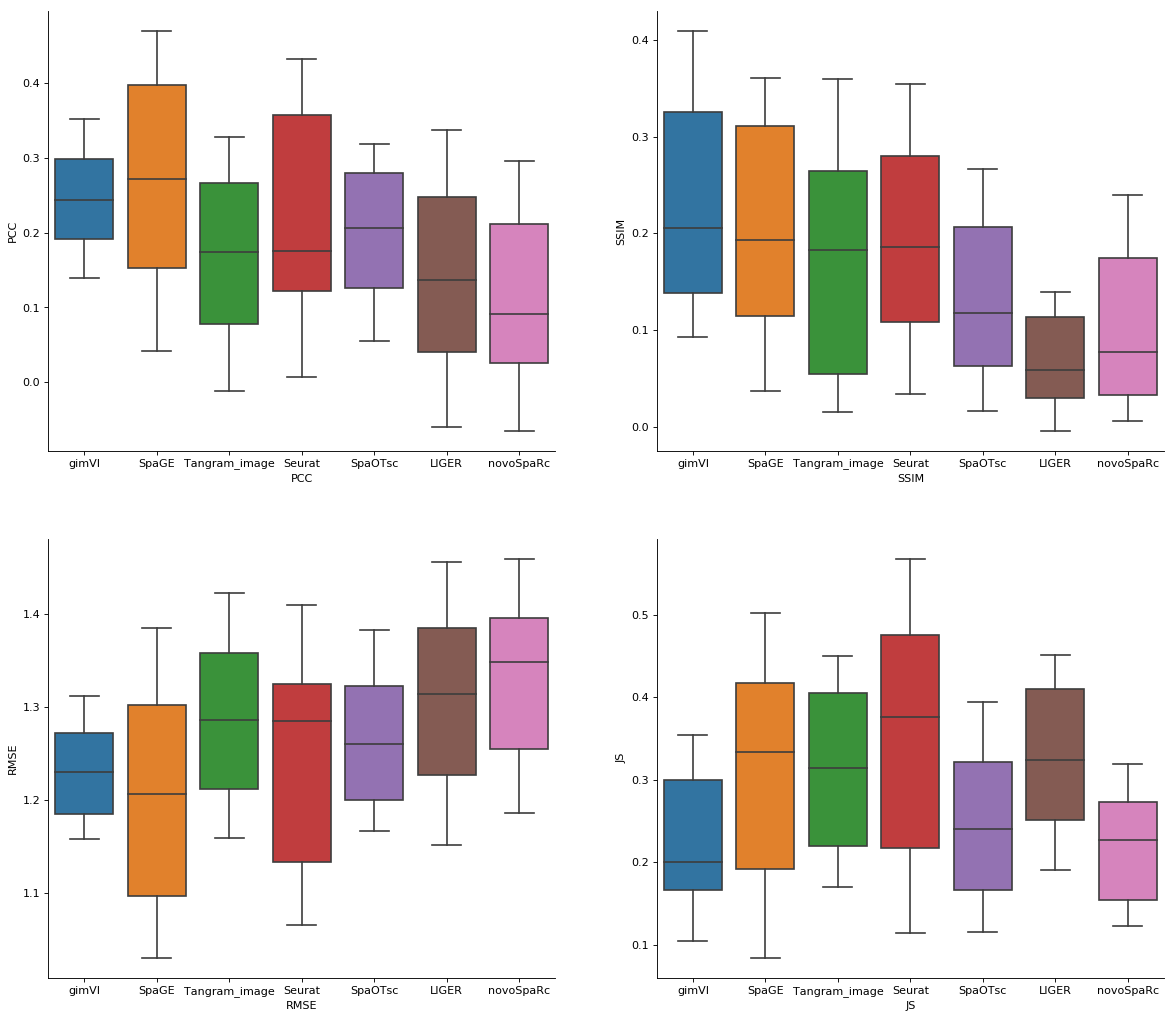

In [18]:
import seaborn as sns
raw_count_file = 'FigureData/Figure2/Dataset2_osmFISH/Rawdata/Insitu_count.txt'
impute_count_path = 'FigureData/Figure2/Dataset2_osmFISH/'
outdir = 'FigureData/Figure2/Dataset2_osmFISH/Metrics/'
metric = ['PCC','SSIM','RMSE','JS']
Tools = ['gimVI','SpaGE','Tangram_image','Seurat','SpaOTsc','LIGER','novoSpaRc']
for tool in Tools:
    CM = CalculateMeteics(raw_count_file = raw_count_file, impute_count_path = impute_count_path, tool = tool, outdir = outdir, metric = metric, Tools = Tools)
    CM.compute_all()
PATH = 'FigureData/Figure2/Dataset2_osmFISH/Metrics/'
result = plot_boxplot(PATH,metric,Tools,outdir)
    

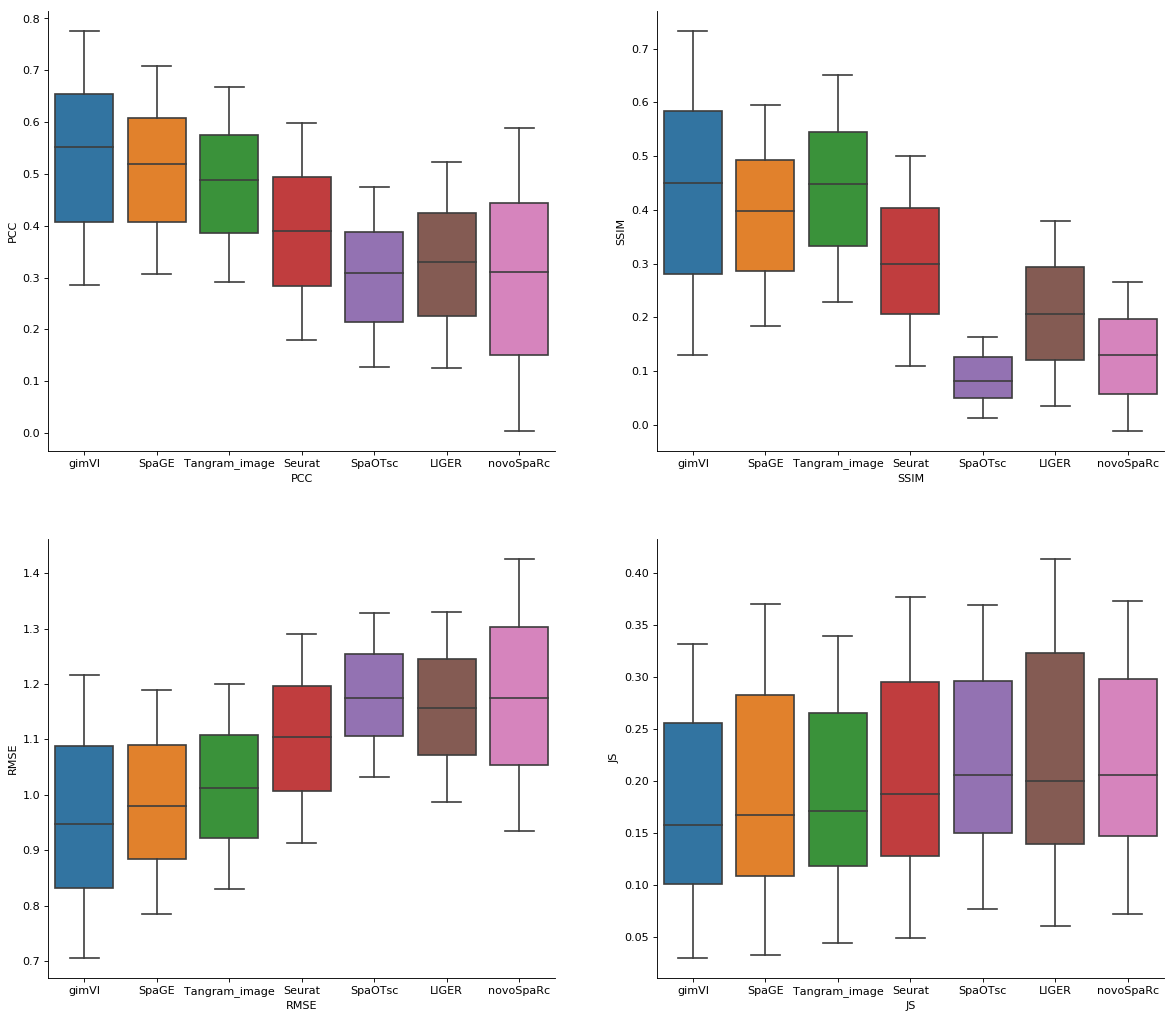

In [19]:
import seaborn as sns
raw_count_file = 'FigureData/Figure2/Dataset4_seqFISH+/Rawdata/Insitu_count.txt'
impute_count_path = 'FigureData/Figure2/Dataset4_seqFISH+/'
outdir = 'FigureData/Figure2/Dataset4_seqFISH+/Metrics/'
metric = ['PCC','SSIM','RMSE','JS']
Tools = ['gimVI','SpaGE','Tangram_image','Seurat','SpaOTsc','LIGER','novoSpaRc']
for tool in Tools:
    CM = CalculateMeteics(raw_count_file = raw_count_file, impute_count_path = impute_count_path, tool = tool, outdir = outdir, metric = metric, Tools = Tools)
    CM.compute_all()
PATH = 'FigureData/Figure2/Dataset4_seqFISH+/Metrics/'
result = plot_boxplot(PATH,metric,Tools,outdir)